In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Anomaly Detection") \
    .getOrCreate()

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FitFailedWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
np.random.seed(42)

In [6]:
df = spark.read.csv('./anomaly-class-detection/train/train.csv', header=True, inferSchema=True)
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

# Cast each column to float type
df = df.withColumn("RSI_signal", col("RSI_signal").cast(FloatType()))
df = df.withColumn("Stoch_O_signal", col("Stoch_O_signal").cast(FloatType()))
df = df.withColumn("fibonacci_signal", col("fibonacci_signal").cast(FloatType()))
df = df.withColumn("Bollinger_signal", col("Bollinger_signal").cast(FloatType()))
df = df.withColumn("ichimoku_c_signal", col("ichimoku_c_signal").cast(FloatType()))

y = df.select('result')
X = df.drop('result')
X.show()

+--------+------------------+----------+--------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+------------------+------------------+------------------+------------------+--------------------+--------------+-----------+---------------+------------------+---------------+------------------+---------------+------------------+----------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------------------+--------------------+-------------------------+-------------------------+-----------------+--------------------+--------------------+
|exchange|               RSI|RSI_signal|                 ATR|      EMA_relative|       MA_relative|        SMA_relative|        WMA_relative|                MACD|       MACD_relative|MACD_relative_signal|MACD_relative_histogram|               ADX|   Stoch_O_k_valu

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# Assemble features
assembler = VectorAssembler(inputCols=X.columns, outputCol="features")
X = assembler.transform(X)

# Split data into training and test sets
(train_data, test_data) = X.randomSplit([0.8, 0.2])

# Use the RandomForest classifier
rf_classifier = RandomForestClassifier(labelCol='result', featuresCol='features')
model = rf_classifier.fit(train_data)

# Predictions
predictions = model.transform(test_data)


IllegalArgumentException: Data type string of column exchange is not supported.

In [ ]:
cat_desc = X.describe(include='object')
cat_desc

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
X[cat_desc.columns.to_list()] = ordinal_encoder.fit_transform(X[cat_desc.columns.to_list()])
X

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

EDA

Our dataset is imbalanced

In [8]:
y.value_counts()
y = y.to_numpy()

In [9]:
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

# Calculate the indices for splitting
train_idx = int(X.shape[0] * train_ratio)
val_idx = int(X.shape[0] * (train_ratio + val_ratio))

# Split the data
X_train = X[:train_idx]
X_val = X[train_idx:val_idx]
X_test = X[val_idx:]

y_train = y[:train_idx]
y_val = y[train_idx:val_idx]
y_test = y[val_idx:]

Given that our training set is imbalanced, we can use alternative metrics to measure performance of different classifiers (e.g f1)

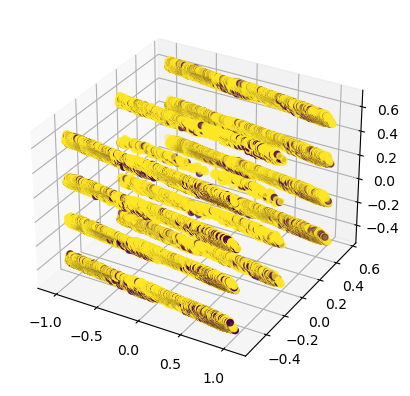

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_train_reduced = pca.fit_transform(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c=y_train)
plt.show()


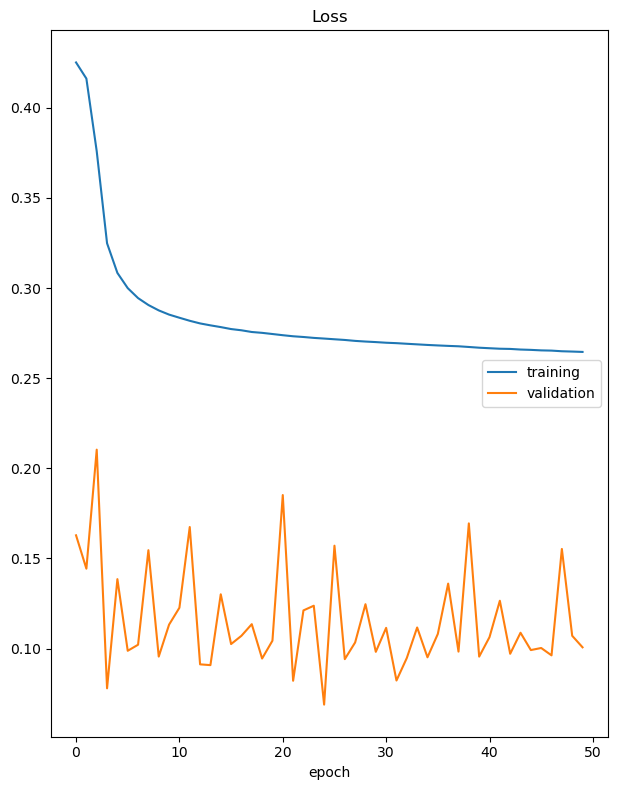

Loss
	training         	 (min:    0.265, max:    0.425, cur:    0.265)
	validation       	 (min:    0.069, max:    0.210, cur:    0.101)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from livelossplot import PlotLosses
# Assuming X_train, y_train, X_val, y_val are NumPy arrays
# Convert them to PyTorch tensors and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

class BetterModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(BetterModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, output_size)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.output_layer(x))
        return x


# Set input size and output size based on your problem
input_size = X_train.shape[1]  # number of features
output_size = 1  # or the number of output classes in classification

net = BetterModel(input_size, output_size)
net.to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    net = nn.DataParallel(net)
# Loss function and optimizer
criterion = nn.BCELoss()  # or another suitable loss function
optimizer = optim.SGD(net.parameters(), lr=0.01)

# Create DataLoader for training and validation sets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=1024)

# Training loop
# Create an instance of PlotLosses from livelossplot
liveplot = PlotLosses()

num_epochs = 50  # or another number of your choice

for epoch in range(num_epochs):
    logs = {}
    
    net.train()
    running_loss = 0.0
    
    # Training Loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels.view(-1, 1))  # adding .view(-1, 1) here
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    logs['loss'] = epoch_loss
    
    # Validation Loop
    net.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = net(inputs)
            loss = criterion(outputs, labels.view(-1, 1))  # adding .view(-1, 1) here
            val_loss += loss.item() * inputs.size(0)
        
    val_loss /= len(val_loader.dataset)
    logs['val_loss'] = val_loss
    
    liveplot.update(logs)
    liveplot.send()
    
torch.save(net.state_dict(), 'model.pth')

In [13]:
# model = BetterModel(input_size, output_size).to(device)
# model.load_state_dict(torch.load('model.pth'))

# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model)

# # 3. Set the model to evaluation mode
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
net.eval()

# 4. Make predictions
with torch.no_grad():
    predictions = net(X_test)
binary_predictions = (predictions > 0.5).float()

# 5. Calculate accuracy
correct = (binary_predictions.view(-1) == y_test.view(-1)).sum().item()
accuracy = correct / y_test.size(0)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 97.18%
